1. 데이터 수집

2. 데이터 전처리
 - 1) 토큰화
 - 2) POS 태깅
 - 3) 불용어 처리

3. 감정 사전 구축
 - Word2Vec을 사용한 단어 학습 (CBOW 사용)

4. 감정 분류
 - 1) 단어 임베딩
 - 2) LSTM을 활용한 감정 분류 모델 구축

 - Word2Vec(skip-gram or **LSTM**)을 사용 

5. 감정 유사도 계산
 - 단어 간 거리 유사도 판별 (Word2Vec 임베딩 모델 사용)

6. 실험 평가
 - 1) Word2Vec 모델 바교
 - 2) 문맥 의미 파악
 - 3) 모델 비교 실험
    - SVM
    - Logistic Regression
    - LSTM
 - 4) 신규 가사 감정 테스트
 - 5) 기존 연구와 비교분석  


## 0. 학습준비

파일 10번부터 참고

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 사용할 라이브러리 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import math
import time

In [ ]:
# konlyp 및 mecab install
!pip install konlpy
!curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

In [ ]:
!pip install kss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.4 MB 1.3 MB/s 
     |████████████████████████████████| 131 kB 40.0 MB/s 
  Created wheel for kss: filename=kss-3.4.3-py3-none-any.whl size=42448068 sha256=4b8f412aaf7fd38bc9cc1bb92ed47c884ee1cf2db9d5341091d6878d659e27fe
  Stored in directory: /root/.cache/pip/wheels/10/df/7d/0d0a58843aa7d267687671cf57274080bcfe8f79d59ed8f399
Successfully built kss


# 1. 데이터 불러오기


In [ ]:
## csv파일 불러오기
base_path = '/content/drive/MyDrive/nlp미니프로젝트/'
data = pd.read_csv(base_path + 'm0728.csv', delimiter=',', header=0)
# 불필요한 컬럼 제거
data = data.drop(['Unnamed: 0'],axis=1)
data.tail(3)

,가사
5463,현아 날 버리지 말아요 현아 날 떠나지 말아요 현아 당신 떠나시면 이 슬픔 정말 어...
5464,그때는 믿지 않았지 웃어버렸지 사랑하면서도 헤어져야 한다는 말에 아직도 믿진 않지만...
5465,단 한번 단 한번밖에 못해도 그래도 널 사랑할 수 있을까 내 전불 다 걸고 내 앞에...


In [ ]:
# train, test 분리
train = data[:round(0.8*len(data))]
test = data[round(0.8*len(data)):]

print('train:',len(train)
      ,'\ntest:',len(test)
      ,'\n-----------------'
      ,'\ntrain + test:',len(train + test)
      ,'\ndata:',len(data))

train: 4373 
test: 1093 
----------------- 
train + test: 5466 
data: 5466


In [ ]:
## 예제 문장 하나 불러오기
example = train.iloc[16, -1]
example

'그댄 쉽나요 날 잊고 사는게 죽을 것만 같은데 그댈 지우는 일 다른 사랑이 날 잊게 하나요 어쩜 그럴 수 있죠 내 전부였잖아 날 많이 아껴주고 지켜줬는데 여전히 내 가슴은 그대만 찾는데 그댄 나쁜 남자죠 사랑한 줄도 모르고 그대 떠나가네요 소리쳐 불러보지만 행복하길 바란다는 그 말 너무 미운데 자꾸 눈물만 나죠 어떻게 그댈 잊기싫은데  누구도 내 맘 속에 자리할 순 없죠 다시는 그대 같은 사랑 못할까봐 그댄 나쁜 남자죠 사랑한 줄도 모르고 그대 떠나가네요 소리쳐 불러보지만 행복하길 바란다는 그 말 너무 미운데 자꾸 눈물만 나죠 그대를 잊기 싫은데 가끔 기억해줘요 사랑한 여자였다고 그댈 원망할게요 그걸로 살 수 있다면 혹시 모르잖아요 그대가 돌아온다면 우리 좋았던 추억 그 하나로 그댈 기다릴게요 잘 지내요 우리 만날 때 까지'

# 2. 데이터 전처리

특수문자, html tag 등을 제거하여 자연어 데이터만 남김


In [ ]:
# csv파일 병합 파일에서 1차적으로 특수문자 제거 완료

# 정규 표현식으로 데이터 정제
# 한글과 공백을 제외하고 모두 제거
train['가사'] = train['가사'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,가사
0,단 한번 단 한번밖에 못해도 그래도 널 사랑할 수 있을까 내 전불 다 걸고 내 앞에...
1,시간을 멈출수 있다면 온 힘을 다해 막을텐데 어쩌면 우리 오늘이 마지막인데 잠시후면...
2,그리던 꿈처럼 내 맘속에 갑자기 찾아온 그대 멀리서 바라만 봤었던 하늘의 조각이었는...
3,보랏빛으로 물든 하늘 쓸쓸한 바람에 더욱 시려오는 밤 내 맘에 새겨진 익숙한 기억들...
4,믿을수 있나요 나의 꿈 속에서 너는 마법에 빠진 공주란 걸 언제나 너를 향한 몸짓엔...
...,...
4368,우린 이제 어딜 향하나 한 줄기 빛이 나에게 내려 멀어진다 해도 그...
4369,쉽게 사랑이라 말하고 쉽게 돌아서곤 했었지 나에겐 사랑이란 말은 그저 나 자신에게 ...
4370,오늘밤에 오늘밤에 우리사랑을 속삭여요 내마음이 뜨거워요 나를 만나줘요 낭만을 마시며...
4371,힘들게 보낸 나의 하루에 짧은 입맞춤을 해 주던 사람 언젠가 서로가 더 먼 곳을 보...


## 2-1. 토큰화
문자열을 다차원의 벡터 형태로 바꿔주는 과정

자연어 데이터를 토큰으로 나누어줌 (한국어의 경우 띄어쓰기와 형태소 활용 추천)


- 토큰: 임베딩의 단위
- 임베딩: 변환된 벡터들이 존재히는 공간

- 단어 임베딩: 말뭉치(코퍼스)가 포함된 단어들이 각각의 좌표를 가지도록 형성된 공간

- 문장 임베딩

In [ ]:
'''
# NLTK는 영어 분석할 때 사용
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer


import nltk
nltk.download('punkt')
'''

"\n# NLTK는 영어 분석할 때 사용\nfrom nltk.tokenize import word_tokenize\nfrom nltk.tokenize import WordPunctTokenizer\n\n\nimport nltk\nnltk.download('punkt')\n"

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator # 토큰의 목록 또는 반복자를 받는 내장 팩토리 함수

#한글 문장 토큰화 하기 위해 필요 (korean sentence splitter)
import kss

# konlpy에서 라이브러리 불러오기
from konlpy.tag import Kkma
from konlpy.tag import Hannanum
from konlpy.tag import Komoran
from konlpy.tag import Okt
from konlpy.tag import Mecab

In [ ]:
# 형태소 분석을 위한 객체 생성
# 꼬꼬마
kkma = Kkma()
# 코모란
komoran = Komoran()
# # 한나눔
hannanum = Hannanum()      # 너무 느려서 사용 안함
# Okt
okt = Okt()
# Mecab                    
mecab = Mecab()

# 토큰화 함수 : 토큰 타입을 변경하고 싶으면 return 부분 수정  
# 품사 태깅 퀄리티: 꼬꼬마 > 코모란 > Okt            # .morphs는 형태소만 추출   .pos는 형태소 + 품사 모두 추출   .nouns는 명사 추출
def tokenizer(row):
    return mecab.nouns(row)

In [ ]:
# kkma.nouns(train['가사'][0])
# komoran.nouns(train['가사'][0])
# hannanum.nouns(train['가사'][0])
# okt.nouns(train['가사'][0])
mecab.nouns(train['가사'][4])

['수',
 '나',
 '꿈',
 '속',
 '너',
 '마법',
 '공주',
 '걸',
 '너',
 '몸짓',
 '뿐',
 '굳',
 '뿐',
 '너',
 '거',
 '손',
 '기도',
 '끝',
 '용기',
 '지혜',
 '마법',
 '성',
 '늪',
 '어둠',
 '동굴',
 '속',
 '그대',
 '나',
 '손',
 '우리',
 '몸',
 '것',
 '자유',
 '하늘',
 '우리',
 '앞',
 '세상',
 '마법',
 '성',
 '늪',
 '어둠',
 '동굴',
 '속',
 '그대',
 '나',
 '손',
 '우리',
 '몸',
 '것',
 '자유',
 '하늘',
 '우리',
 '앞',
 '세상']

In [ ]:
# 불용어 정의
stopwords_NN = ['번','수','말','텐데','걸','손','나','너','앞','척','게','때','전','것','듯','부서','내','거','하나','둘','셋','걸음','곁','날']



In [ ]:
# 토큰화된 가사 저장
tokenized = []

# 불용어가 추가된 형태소 분석기
for sentence in train['가사']:
  # 토큰화
  temp = tokenizer(sentence)
  # 불용어 제거
  temp = [word for word in temp if word not in stopwords_NN] 
  tokenized.append(temp)

tokenized

In [ ]:
# 최빈도로 추출한 명사 키워드 분류 카테고리
# 필요한 라이브러리 import
from collections import Counter
import collections

#토큰화 된 가사 저장
tokenized = []
# 곡별로 추출한 NNP, NNG 저장할 리스트 
NN_list = []


#NNP(고유 명사), NNG(일반 명사) 추출   / 시작 전 형태소 분석기 모델 선택! 품질은 kkma, hannanum 추천 , 속도는 Mecab , okt 추천
for i in range(len(train)):  
  # Null 에러가 나기 때문에 try,except 지정 
  try:
    temp = pd.DataFrame(kkma.pos(train['가사'][i]))
    to_list = list(temp[(temp[1].str.contains('NNG')) | (temp[1].str.contains('NNP'))][0])
    # 뽑아낸 키워드 상위 5개만 분류
    temp2 = collections.Counter(to_list).most_common(5)
    NN_list.append(temp2)
  except:
    # 영어 노래 또는 Null값이 너무 많은 노래 키워드 'x'로 지정
    NN_list.append('x')
NN_list

# kkma >> 33분 50초 (너무 코퍼스가 큰 단위로 분류 ex. '사랑해'를 사랑+해 형태로 분류하여 '사랑'이라는 단어에 가중치 손해 봄 )

[[('사랑', 4), ('단', 3), ('한번', 3), ('앞', 2), ('널', 2)],
 [('조금', 3), ('마지막', 2), ('부탁', 2), ('사랑', 2), ('시간', 1)],
 [('걸음', 6), ('하나', 6), ('둘', 6), ('이젠', 2), ('바다', 2)],
 [('하늘', 5), ('맘', 5), ('밤', 4), ('곁', 4), ('별', 3)],
 [('속', 3), ('마법', 3), ('손', 3), ('성', 2), ('건너', 2)],
 [('눈', 3), ('날', 3), ('마음', 3), ('행복', 3), ('눈물', 2)],
 [('사랑', 6), ('이별', 4), ('하루', 4), ('널', 3), ('기억', 3)],
 [('사랑', 3), ('시간', 3), ('날', 3), ('맘', 3), ('속', 3)],
 [('사랑', 11), ('부족', 4), ('행복', 3), ('가요', 3), ('미안', 1)],
 [('날', 4), ('꿈', 2), ('어깨', 2), ('위', 2), ('삶', 2)],
 [('사랑', 5), ('날', 2), ('거짓말', 2), ('조금', 1), ('이해', 1)],
 [('달무리', 5), ('달', 4), ('달맞이꽃', 3), ('위', 2), ('적막', 1)],
 [('날', 4), ('노래', 4), ('감사', 4), ('행복', 3), ('이젠', 3)],
 [('장미', 7), ('부', 4), ('꽃', 3), ('내음', 3), ('잎사귀', 2)],
 [('사랑', 6), ('바보', 5), ('생각', 3), ('달빛', 2), ('이별', 2)],
 [('사랑', 5), ('나의', 4), ('내가', 3), ('가슴', 3), ('널', 3)],
 [('사랑', 4), ('날', 3), ('남', 2), ('행복', 2), ('말', 2)],
 'x',
 [('사랑', 13), ('거짓말', 6), ('마', 

In [ ]:
train['NN'] = NN_list
train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,가사,토큰,NN
0,단 한번 단 한번밖에 못해도 그래도 널 사랑할 수 있을까 내 전불 다 걸고 내 앞에...,"[단, 한, 번, 단, 한, 번, 밖에, 못, 해도, 그래도, 널, 사랑, 할, 수...","[(사랑, 4), (단, 3), (한번, 3), (앞, 2), (널, 2)]"
1,시간을 멈출수 있다면 온 힘을 다해 막을텐데 어쩌면 우리 오늘이 마지막인데 잠시후면...,"[시간, 을, 멈출, 수, 있, 다면, 온, 힘, 을, 다, 해, 막, 을, 텐데,...","[(조금, 3), (마지막, 2), (부탁, 2), (사랑, 2), (시간, 1)]"
2,그리던 꿈처럼 내 맘속에 갑자기 찾아온 그대 멀리서 바라만 봤었던 하늘의 조각이었는...,"[그리, 던, 꿈, 처럼, 내, 맘속, 에, 갑자기, 찾아온, 그대, 멀리서, 바라...","[(걸음, 6), (하나, 6), (둘, 6), (이젠, 2), (바다, 2)]"
3,보랏빛으로 물든 하늘 쓸쓸한 바람에 더욱 시려오는 밤 내 맘에 새겨진 익숙한 기억들...,"[보랏빛, 으로, 물든, 하늘, 쓸쓸, 한, 바람, 에, 더욱, 시려, 오, 는, ...","[(하늘, 5), (맘, 5), (밤, 4), (곁, 4), (별, 3)]"
4,믿을수 있나요 나의 꿈 속에서 너는 마법에 빠진 공주란 걸 언제나 너를 향한 몸짓엔...,"[믿, 을, 수, 있, 나요, 나, 의, 꿈, 속, 에서, 너, 는, 마법, 에, ...","[(속, 3), (마법, 3), (손, 3), (성, 2), (건너, 2)]"
...,...,...,...
4368,우린 이제 어딜 향하나 한 줄기 빛이 나에게 내려 멀어진다 해도 그...,"[우린, 이제, 어딜, 향하, 나, 한, 줄기, 빛, 이, 나, 에게, 내려, 멀,...","[(빛, 4), (줄기, 2), (향, 1), (널, 1), (날, 1)]"
4369,쉽게 사랑이라 말하고 쉽게 돌아서곤 했었지 나에겐 사랑이란 말은 그저 나 자신에게 ...,"[쉽, 게, 사랑, 이, 라, 말, 하, 고, 쉽, 게, 돌아서, 곤, 했었, 지,...","[(사랑, 9), (얘기, 4), (사랑이, 3), (말, 3), (처음, 2)]"
4370,오늘밤에 오늘밤에 우리사랑을 속삭여요 내마음이 뜨거워요 나를 만나줘요 낭만을 마시며...,"[오늘, 밤, 에, 오늘, 밤, 에, 우리, 사랑, 을, 속삭여, 요, 내, 마음,...","[(사랑, 6), (밤, 5), (오늘밤, 5), (마음, 4), (전, 4)]"
4371,힘들게 보낸 나의 하루에 짧은 입맞춤을 해 주던 사람 언젠가 서로가 더 먼 곳을 보...,"[힘들, 게, 보낸, 나, 의, 하루, 에, 짧, 은, 입맞춤, 을, 해, 주, 던...","[(사람, 5), (거짓말, 4), (안부, 2), (얘기, 2), (예감, 2)]"


In [ ]:
# 형태소 분석 
# join을 통해 한문장으로 출력
" ".join(tokenizer(example))

TypeError: ignored

In [ ]:
# 각 노래를 토큰화 하여 새로운 컬럼으로 저장

# 시작 시간 저장
start = time.time()

#토큰화
train['토큰'] = train['가사'].apply(tokenizer)

# 마무리 시간 저장
math.factorial(100000)
end = time.time()
print(f'{end - start:.4f} sec')
print('최대 토큰 개수 : ',max(len(i) for i in train['토큰']))
print('평균 토큰 개수 : ',sum(map(len,train['토큰']))/len(train['토큰']))
train

5.9345 sec
최대 토큰 개수 :  708
평균 토큰 개수 :  216.59432883603932


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,가사,토큰
0,단 한번 단 한번밖에 못해도 그래도 널 사랑할 수 있을까 내 전불 다 걸고 내 앞에...,"[단, 한, 번, 단, 한, 번, 밖에, 못, 해도, 그래도, 널, 사랑, 할, 수..."
1,시간을 멈출수 있다면 온 힘을 다해 막을텐데 어쩌면 우리 오늘이 마지막인데 잠시후면...,"[시간, 을, 멈출, 수, 있, 다면, 온, 힘, 을, 다, 해, 막, 을, 텐데,..."
2,그리던 꿈처럼 내 맘속에 갑자기 찾아온 그대 멀리서 바라만 봤었던 하늘의 조각이었는...,"[그리, 던, 꿈, 처럼, 내, 맘속, 에, 갑자기, 찾아온, 그대, 멀리서, 바라..."
3,보랏빛으로 물든 하늘 쓸쓸한 바람에 더욱 시려오는 밤 내 맘에 새겨진 익숙한 기억들...,"[보랏빛, 으로, 물든, 하늘, 쓸쓸, 한, 바람, 에, 더욱, 시려, 오, 는, ..."
4,믿을수 있나요 나의 꿈 속에서 너는 마법에 빠진 공주란 걸 언제나 너를 향한 몸짓엔...,"[믿, 을, 수, 있, 나요, 나, 의, 꿈, 속, 에서, 너, 는, 마법, 에, ..."
...,...,...
4368,우린 이제 어딜 향하나 한 줄기 빛이 나에게 내려 멀어진다 해도 그...,"[우린, 이제, 어딜, 향하, 나, 한, 줄기, 빛, 이, 나, 에게, 내려, 멀,..."
4369,쉽게 사랑이라 말하고 쉽게 돌아서곤 했었지 나에겐 사랑이란 말은 그저 나 자신에게 ...,"[쉽, 게, 사랑, 이, 라, 말, 하, 고, 쉽, 게, 돌아서, 곤, 했었, 지,..."
4370,오늘밤에 오늘밤에 우리사랑을 속삭여요 내마음이 뜨거워요 나를 만나줘요 낭만을 마시며...,"[오늘, 밤, 에, 오늘, 밤, 에, 우리, 사랑, 을, 속삭여, 요, 내, 마음,..."
4371,힘들게 보낸 나의 하루에 짧은 입맞춤을 해 주던 사람 언젠가 서로가 더 먼 곳을 보...,"[힘들, 게, 보낸, 나, 의, 하루, 에, 짧, 은, 입맞춤, 을, 해, 주, 던..."


In [ ]:
# 불용어 정의
stopwords = ['의','가','이','은','는','들','좀','쫌','잘','걍','도','를','을','으로','로','자','에','와','에게','과','해','가까스로','가령','각','각각','각자','각종','갖고말하자면','같다','같이','개의치않고','거니와','거바','거의','것','것과 같이','것들','게다가','게우다','겨우','견지에서','결과에 이르다','결국','결론을 낼 수 있다','겸사겸사','고려하면','고로','곧','공동으로','과','과연','관계가 있다','관계없이','관련이 있다','관하여','관한','관해서는','구','구체적으로','구토하다','그','그들','그때','그래','그래도','그래서','그러나','그러니','그러니까','그러면','그러므로','그러한즉','그런 까닭에','그런데','그런즉','그럼','그럼에도 불구하고','그렇게 함으로써','그렇지','그렇지 않다면','그렇지 않으면','그렇지만','그렇지않으면','그리고','그리하여','그만이다','그에 따르는','그위에','그저','그중에서','그치지 않다','근거로','근거하여','기대여','기점으로','기준으로','기타','까닭으로','까악','까지','까지 미치다','까지도','꽈당','끙끙','끼익','나','나머지는','남들','남짓','너','너희','너희들','네','넷','년','논하지 않다','놀라다','누가 알겠는가','누구','다른','다른 방면으로','다만','다섯','다소','다수','다시 말하자면','다시말하면','다음','다음에','다음으로','단지','답다','당신','당장','대로 하다','대하면','대하여','대해 말하자면','대해서','댕그','더구나','더군다나','더라도','더불어','더욱더','더욱이는','도달하다','도착하다','동시에','동안','된바에야','된이상','두번째로','둘','둥둥','뒤따라','뒤이어','든간에','들','등','등등','딩동','따라','따라서','따위','따지지 않다','딱','때','때가 되어','때문에','또','또한','뚝뚝','라 해도','령','로','로 인하여','로부터','로써','륙','를','마음대로','마저','마저도','마치','막론하고','만 못하다','만약','만약에','만은 아니다','만이 아니다','만일','만큼','말하자면','말할것도 없고','매','매번','메쓰겁다','몇','모','모두','무렵','무릎쓰고','무슨','무엇','무엇때문에','물론','및','바꾸어말하면','바꾸어말하자면','바꾸어서 말하면','바꾸어서 한다면','바꿔 말하면','바로','바와같이','밖에 안된다','반대로','반대로 말하자면','반드시','버금','보는데서','보다더','보드득','본대로','봐','봐라','부류의 사람들','부터','불구하고','불문하고','붕붕','비걱거리다','비교적','비길수 없다','비로소','비록','비슷하다','비추어 보아','비하면','뿐만아니라','뿐이다','삐걱','삐걱거리다','사','삼','상대적으로 말하자면','생각한대로','설령','설마','설사','셋','소생','소인','솨','쉿','습니까','습니다','시각','시간','시작하여','시초에','시키다','실로','심지어','아','아니','아니나다를가','아니라면','아니면','아니었다면','아래윗','아무거나','아무도','아야','아울러','아이','아이고','아이구','아이야','아이쿠','아하','아홉','안 그러면','않기 위하여','않기 위해서','알 수 있다','알았어','앗','앞에서','앞의것','야','약간','양자','어','어기여차','어느','어느 년도','어느것','어느곳','어느때','어느쪽','어느해','어디','어때','어떠한','어떤','어떤것','어떤것들','어떻게','어떻해','어이','어째서','어쨋든','어쩔수 없다','어찌','어찌됏든','어찌됏어','어찌하든지','어찌하여','언제','언젠가','얼마','얼마 안 되는 것','얼마간','얼마나','얼마든지','얼마만큼','얼마큼','엉엉','에','에 가서','에 달려 있다','에 대해','에 있다','에 한하다','에게','에서','여','여기','여덟','여러분','여보시오','여부','여섯','여전히','여차','연관되다','연이서','영','영차','옆사람','예','예를 들면','예를 들자면','예컨대','예하면','오','오로지','오르다','오자마자','오직','오호','오히려','와','와 같은 사람들','와르르','와아','왜','왜냐하면','외에도','요만큼','요만한 것','요만한걸','요컨대','우르르','우리','우리들','우선','우에 종합한것과같이','운운','월','위에서 서술한바와같이','위하여','위해서','윙윙','육','으로','으로 인하여','으로서','으로써','을','응','응당','의','의거하여','의지하여','의해','의해되다','의해서','이','이 되다','이 때문에','이 밖에','이 외에','이 정도의','이것','이곳','이때','이라면','이래','이러이러하다','이러한','이런','이럴정도로','이렇게 많은 것','이렇게되면','이렇게말하자면','이렇구나','이로 인하여','이르기까지','이리하여','이만큼','이번','이봐','이상','이어서','이었다','이와 같다','이와 같은','이와 반대로','이와같다면','이외에도','이용하여','이유만으로','이젠','이지만','이쪽','이천구','이천육','이천칠','이천팔','인 듯하다','인젠','일','일것이다','일곱','일단','일때','일반적으로','일지라도','임에 틀림없다','입각하여','입장에서','잇따라','있다','자','자기','자기집','자마자','자신','잠깐','잠시','저','저것','저것만큼','저기','저쪽','저희','전부','전자','전후','점에서 보아','정도에 이르다','제','제각기','제외하고','조금','조차','조차도','졸졸','좀','좋아','좍좍','주룩주룩','주저하지 않고','줄은 몰랏다','줄은모른다','중에서','중의하나','즈음하여','즉','즉시','지든지','지만','지말고','진짜로','쪽으로','차라리','참','참나','첫번째로','쳇','총적으로','총적으로 말하면','총적으로 보면','칠','콸콸','쾅쾅','쿵','타다','타인','탕탕','토하다','통하여','툭','퉤','틈타','팍','팔','퍽','펄렁','하','하게될것이다','하게하다','하겠는가','하고 있다','하고있었다','하곤하였다','하구나','하기 때문에','하기 위하여','하기는한데','하기만 하면','하기보다는','하기에','하나','하느니','하는 김에','하는 편이 낫다','하는것도','하는것만 못하다','하는것이 낫다','하는바','하더라도','하도다','하도록시키다','하도록하다','하든지','하려고하다','하마터면','하면 할수록','하면된다','하면서','하물며','하여금','하여야','하자마자','하지 않는다면','하지 않도록','하지마','하지마라','하지만','하하','한 까닭에','한 이유는','한 후','한다면','한다면 몰라도','한데','한마디','한적이있다','한켠으로는','한항목','할 따름이다','할 생각이다','할 줄 안다','할 지경이다','할 힘이 있다','할때','할만하다','할망정','할뿐','할수있다','할수있어','할줄알다','할지라도','할지언정','함께','해도된다','해도좋다','해봐요','해서는 안된다','해야한다','해요','했어요','향하다','향하여','향해서','허','허걱','허허','헉','헉헉','헐떡헐떡','형식으로 쓰여','혹시','혹은','혼자','훨씬','휘익','휴','휴','흐흐','흥','힘입어','단','한','번','밖에','못','해도','널','할','수','있','을까','내','전불','다', '걸', '고', '앞', '남', '많','고', '걸', '어떡', '손', '가려서', '피해', '질', '겠', '니', '뜰', '없', '인데', '하룰', '살', '아도', '쓰', '고', '싶', '은데', '쉽', '지', '않', '자꾸', '잃', '게', '더', '향한', '가슴','던','데','죠','씩','만','말','날','난','면','같','보','거','했','처럼','었','안','사람','다시','알','잊','기','속','눈','주','좋','길','너무','되','는데','서','았','밤','오늘','이렇게','웃','곁','줘','하루','내게','모든','며','두','아직','넌','줄','아요','모습','지금','끝','어요','울','그댈','없이','인','마','뿐','건','엔','나요','잖아','는지','듯','순간','요','정말','모르','보다','라고','돼','괜찮','다면','잡','어도','란','이제','떠나','다고','니까','라','곳','아무','찾','라도','그렇게','볼','그런','매일','믿','늘','우린','아서','힘들','아프','처음','서로','숨','언제나','버린','으면','멀','그냥','많이','도록','네요 ','어서','진','만나','네요','걷','보내','항상','꼭','라는','바라보','작','싫','지나','가득','놓','위해','뭐','감','다는','제발','다가','가끔','준','줘요','멀리','보이','했었','면서','못하','테','려','채','될','닿','위','내겐','바라','죽','봐도','소중','였','땐','그댄','긴','봐요','져','아닌','듣','척','몰라','흐르','뒤','거리']


In [ ]:
# 토큰화된 가사 저장
tokenized = []

# 불용어가 추가된 형태소 분석기
for sentence in train['가사']:
  # 토큰화
  temp = tokenizer(sentence)
  # 불용어 제거
  temp = [word for word in temp if word not in stopwords] 
  tokenized.append(temp)

tokenized

In [ ]:
train['불용어제거'] = tokenized
train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,가사,토큰,불용어제거
0,단 한번 단 한번밖에 못해도 그래도 널 사랑할 수 있을까 내 전불 다 걸고 내 앞에...,"[단, 한, 번, 단, 한, 번, 밖에, 못, 해도, 그래도, 널, 사랑, 할, 수...","[사랑, 행복, 버리, 택할, 물음, 대답, 너야, 감춰, 숨겨, 하늘, 그리운, ..."
1,시간을 멈출수 있다면 온 힘을 다해 막을텐데 어쩌면 우리 오늘이 마지막인데 잠시후면...,"[시간, 을, 멈출, 수, 있, 다면, 온, 힘, 을, 다, 해, 막, 을, 텐데,...","[멈출, 온, 힘, 막, 텐데, 어쩌면, 마지막, 후면, 텐데, 천천히, 일어나, ..."
2,그리던 꿈처럼 내 맘속에 갑자기 찾아온 그대 멀리서 바라만 봤었던 하늘의 조각이었는...,"[그리, 던, 꿈, 처럼, 내, 맘속, 에, 갑자기, 찾아온, 그대, 멀리서, 바라...","[그리, 꿈, 맘속, 갑자기, 찾아온, 그대, 멀리서, 봤었, 하늘, 조각, 손안,..."
3,보랏빛으로 물든 하늘 쓸쓸한 바람에 더욱 시려오는 밤 내 맘에 새겨진 익숙한 기억들...,"[보랏빛, 으로, 물든, 하늘, 쓸쓸, 한, 바람, 에, 더욱, 시려, 오, 는, ...","[보랏빛, 물든, 하늘, 쓸쓸, 바람, 더욱, 시려, 맘, 새겨진, 익숙, 기억, ..."
4,믿을수 있나요 나의 꿈 속에서 너는 마법에 빠진 공주란 걸 언제나 너를 향한 몸짓엔...,"[믿, 을, 수, 있, 나요, 나, 의, 꿈, 속, 에서, 너, 는, 마법, 에, ...","[꿈, 마법, 빠진, 공주, 몸짓, 수많, 어려움, 굳, 다짐, 구하, 모아, 기도..."
...,...,...,...
4368,우린 이제 어딜 향하나 한 줄기 빛이 나에게 내려 멀어진다 해도 그...,"[우린, 이제, 어딜, 향하, 나, 한, 줄기, 빛, 이, 나, 에게, 내려, 멀,...","[어딜, 향하, 줄기, 빛, 내려, 진다, 빛, 어딘가, 줄기, 빛, 내려, 사라지..."
4369,쉽게 사랑이라 말하고 쉽게 돌아서곤 했었지 나에겐 사랑이란 말은 그저 나 자신에게 ...,"[쉽, 게, 사랑, 이, 라, 말, 하, 고, 쉽, 게, 돌아서, 곤, 했었, 지,...","[사랑, 돌아서, 곤, 에겐, 사랑, 본, 이미, 삶, 가져갈, 사랑, 왔, 음, ..."
4370,오늘밤에 오늘밤에 우리사랑을 속삭여요 내마음이 뜨거워요 나를 만나줘요 낭만을 마시며...,"[오늘, 밤, 에, 오늘, 밤, 에, 우리, 사랑, 을, 속삭여, 요, 내, 마음,...","[사랑, 속삭여, 마음, 뜨거워요, 낭만, 마시, 음악, 흠뻑, 젖, 밝, 내일, ..."
4371,힘들게 보낸 나의 하루에 짧은 입맞춤을 해 주던 사람 언젠가 서로가 더 먼 곳을 보...,"[힘들, 게, 보낸, 나, 의, 하루, 에, 짧, 은, 입맞춤, 을, 해, 주, 던...","[보낸, 짧, 입맞춤, 먼, 헤어질, 안부, 묻, 어렵, 만드, 얘기, 슬픈, 예감..."


## 2-2. 단어 집합(Vocabulary) 생성

In [ ]:
# 빈도 수 계산 도구인 FreqDist()로 빈도 수 계산
from nltk import FreqDist
vocab = FreqDist(np.hstack(tokenized))

# 상위 500의 단어만 단어 집합으로 저장 (예시)
vocab_size = 500

# 상위 500의 단어만 보존
vocab = vocab.most_common(vocab_size)
print('단어 집합의 크기 : {}'.format(len(vocab)))
most_common = pd.DataFrame(vocab)
most_common.head(5)

단어 집합의 크기 : 500


,0,1
0,사랑,12782
1,그대,8378
2,마음,3147
3,맘,3143
4,눈물,2808


## 2-3. 정수 인코딩

각 단어에 고유한 정수 부여

In [ ]:
# 인덱스 0과 1은 다른 용도를 위해 남겨두고, 나머지 단어들은 2 부터 128까지 순차적으로 인덱스 부여
word_to_index = {word[0] : index + 2 for index, word in enumerate(vocab)}

#패딩용 인덱스 1
word_to_index['pad'] = 1

# unknown 용 인덱스 0
word_to_index['unk'] = 0


# 기존 훈련 데이터에서 각 단어를 고유한 정수로 부여
encoded = []

for line in tokenized:
  temp =[]
  for w in line:
    try:
      temp.append(word_to_index[w])
    except KeyError:
      temp.append(word_to_index['unk'])
    encoded.append(temp)

## 2-4. 패딩

길이가 다른 문장들을 모두 동일한 길이로 변환하는 작업

가사의 최대 길이 : 358
가사의 최소 길이 : 4
가사의 평균 길이 : 70.364755


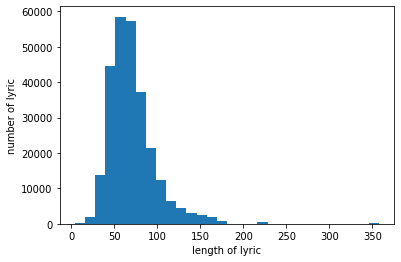

In [ ]:
# 정해줄 길이를 찾기 위해 가장 긴 곡 길이 확인
max_len = max(len(l) for l in encoded)

print('가사의 최대 길이 : %d' % max_len)
print('가사의 최소 길이 : %d' % min(len(l) for l in encoded))
print('가사의 평균 길이 : %f' % (sum(map(len, encoded))/len(encoded)))

plt.hist([len(s) for s in encoded], bins = 30)
plt.xlabel('length of lyric')
plt.ylabel('number of lyric')
plt.show()

In [ ]:
# 모든 가사의 길이를 63으로 통일
for line in encoded:
    if len(line) < max_len: # 현재 샘플이 정해준 길이보다 짧으면
        line += [word_to_index['pad']] * (max_len - len(line)) # 나머지는 전부 'pad' 토큰으로 채운다.

print('가사의 최대 길이 : %d' % max(len(l) for l in encoded))
print('가사의 최소 길이 : %d' % min(len(l) for l in encoded))
print('가사의 평균 길이 : %f' % (sum(map(len, encoded))/len(encoded)))

# 패딩 잘 되었는 지 확인
print(encoded[:3])

가사의 최대 길이 : 358
가사의 최소 길이 : 358
가사의 평균 길이 : 358.000000
[[2, 9, 75, 0, 0, 328, 0, 0, 0, 14, 190, 2, 0, 26, 74, 0, 0, 0, 14, 190, 2, 0, 0, 32, 58, 6, 2, 90, 74, 56, 189, 30, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

## 2-5. 벡터화

# 토큰 임베딩
동일한 토큰화과정을 통해 이미학습된 토큰 임베딩을 찾아서 다운받거나,

word2vec등을 통해 직접 토큰 임베딩을 학습시켜줌


방법: 원-핫 인코딩 or word2vec

word2vec -> context word를 기준으로 skip-gram, continuous bag-of-words 사용

In [ ]:
# word2vec을 사용한 임베딩 진행
from gensim.models import Word2Vec

start = time.time()
model = Word2Vec(sentences=train['불용어제거'], size = 100, window = 5, min_count= 0, workers = 4, sg = 1)

math.factorial(100000)
end = time.time()
print(f'{end - start:.4f} sec')
print(model.wv.vectors.shape)

10.1406 sec
(11954, 100)


In [ ]:
# 입력한 단어와 유사한 키워드 추출
model_result = model.wv.most_similar('사랑')
keywords = pd.DataFrame(model_result)
keywords

,0,1
0,목숨,0.810989
1,미웠,0.808327
2,해줘요,0.805972
3,감히,0.799320
4,한가요,0.798738
5,겁니다,0.792697
6,천,0.792057
7,을께요,0.789448
8,갖,0.789045
9,론,0.788625


# 언어모델 (동음어 다의어 처리)
토큰 임베딩 모아서 문장 임베딩 or 문서 임베딩 학습 진행

(문맥에 맞는 내용을 학습하기 위해 위의 과정 진행)


언어모델: 특정한 문자열(특정 토큰들의 배열)이 등장할 확률을 알려주는 확률모형

ex. GPT or BERT or Transformer

GPT:

BERT:


언어모델의 마지막 레이어를 제거한 뒤, 감성 분석을 위해 0~1의 값을 출력하는 classifier를 마지막 레이어가 있던 자리에 넣어줌.

시그모이드 함수를 활성화함수로 가지는 선형 레이어를 붙여주면 된다.

텍스트 데이터와 레이블링한 감정을 각각 데이터와 레이블로 사용하는 지도학습을 통해 감정 분석을 학습시킴
(언어모델도 함께 fine0tuning 해주는 것이 일반적인 방법)

In [ ]:
'''
# 노래 주제 레이블링

keyword = []
for i in range(len(train)):
  if sum(train['불용어제거'].loc[i].str.contains('친구' or '우정'or'온')) == 1:
    keyword.append('우정')
  elif sum(train['불용어제거'].loc[i].str.contains('고마워' or '감사' or '어머니' or '아버지' or '엄마' or '아빠' or '가족')) == 1:
    keyword.append('가족')
  elif sum(train['불용어제거'].loc[i].str.contains('빛' or '하늘' or '꿈' or '날개' or '세상' or '미래')) == 1:
    keyword.append('희망')
  elif sum(train['불용어제거'].loc[i].str.contains('그리움' or '시간' or '기억' or '약속' or '그리워')) == 1:
    keyword.append('그리움')
  elif sum(train['불용어제거'].loc[i].str.contains('눈물' or '추억' or '이별' or '미안' or '거짓말' or '원망' or '아픔' or '후회')) == 1:
    keyword.append('이별')
  elif sum(train['불용어제거'].loc[i].str.contains('사랑' or '별' or '행복')) == 1:
    keyword.append('사랑')
  else:
    keyword.append('미정')
    
train['주제'] = keyword
train
'''    

AttributeError: ignored

In [ ]:
# 빈도 수 계산 도구인 FreqDist()로 빈도 수 계산
from nltk import FreqDist
vocab_1 = FreqDist(np.hstack(tokenized[1]))

# 상위 500의 단어만 단어 집합으로 저장 (예시)
vocab_size = 3

# 상위 500의 단어만 보존
vocab = vocab.most_common(vocab_size)
print('단어 집합의 크기 : {}'.format(len(vocab)))
most_common = pd.DataFrame(vocab)
most_common.head(5)

AttributeError: ignored

In [ ]:
from collections import counter
count =(nouns)

tag_count = []
tags = []

for n , c in count.most_common(100):
  dics={'tag : n,'count:c}
  if len(dics['tag']) >= 2 and len(tags) <= 49:
    tag_count.append(dics)
    tags.append(dics['tag'])

SyntaxError: ignored

In [ ]:
vocab_1 = FreqDist(np.hstack(tokenized[1]))
vocab_size = 3
vocab = vocab.most_common(vocab_size)
most_common = pd.DataFrame(vocab)
most_common.head(5)

AttributeError: ignored

In [ ]:
# ## label만 떼와서 tok 이라는 pandas DataFrame으로 생성
# tok = pd.DataFrame()
# tok['negative'] = data['negative']
# tok

# 학습평가

지도학습이 끝났다면 토큰임베딩, 언어모델, classifier까지 함께 저장해줌

-> 새로운 텍스트 데이터에 대해 동일한 토큰화, 토큰임베딩, 언어모델을 이용한 inference(추론)과정을 수행하여 학습 평가

In [ ]:
# 퍼플렉서티(PPL)    <- 정량 평가 방법 중 1

In [ ]:
criterion = nn.CrossEntropyLoss()

# create training and validation data
val_idx = int(len(data)*(1-val_frac))
data, val_data = data[:val_idx], data[val_idx:]

if(train_on_gpu):
    net.cuda()

counter = 0
n_chars = len(net.chars)
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    for x, y in get_batches(data, batch_size, seq_length):
        counter += 1

        # One-hot encode our data and make them Torch tensors
        x = one_hot_encode(x, n_chars)
        inputs, targets = torch.from_numpy(x), torch.from_numpy(y)

        if(train_on_gpu):
            inputs, targets = inputs.cuda(), targets.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output, targets.view(batch_size*seq_length))

In [ ]:
criterion = nn.CrossEntropyLoss()
total_loss = 0.
...
for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
    ...
    loss = criterion(output.view(-1, ntokens), targets)
    loss.backward()
    total_loss += loss.item()
    log_interval = 200
    if batch % log_interval == 0 and batch > 0:
        cur_loss = total_loss / log_interval
        ...
        print('ppl {:8.2f}'.format(math.exp(cur_loss)))
        ...